# Gold recovery

## Project description

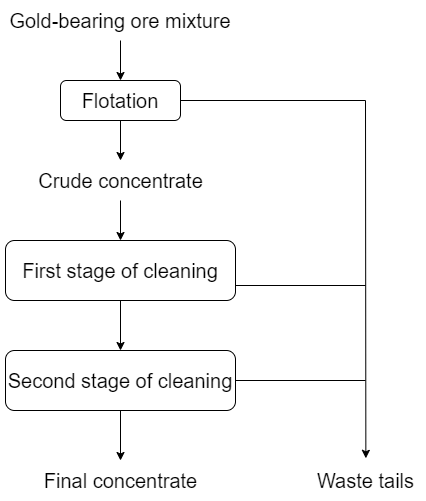

### Data description
#### Technological process
Rougher feed - feedstock  
Rougher additions (or reagent additions) - flotation reagents: Xanthate, Sulphate, Depressant  
Xanthate is a xanthogenate (promoter or activator of flotation);  
Sulphate is sulphate (sodium sulfide in this production);  
Depressant - depressant (sodium silicate).  
Rougher process - flotation  
Rougher tails  
Float banks - flotation plant  
Cleaner process  
Rougher Au - is a rough diamond concentrate  
Final Au - final gold concentrate  
#### Parameters of the stages  
air amount - air volume  
fluid levels  
Feed size - size of raw material pellets  
feed rate - feed rate  
#### Possible values for the [stage] block:  
rougher - flotation  
primary_cleaner - primary cleaner  
secondary_cleaner  
final - final characteristics  
#### Possible values for the [type_parameter] block:  
input - raw material parameters  
output - product parameters  
state - parameters characterizing the current stage state  
calculation - calculation characteristics  

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm

In [2]:
df_train = pd.read_csv('/project/datasets/gold_recovery_train.csv', index_col=0)

In [3]:
df_test = pd.read_csv('/project/datasets/gold_recovery_test.csv', index_col=0)

In [4]:
df_full = pd.read_csv('/project/datasets/gold_recovery_full.csv', index_col=0)

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df_train.shape

(14149, 86)

In [7]:
first_len_train = df_train.shape[0]

In [8]:
df_test.shape

(5290, 52)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                             

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

In [11]:
df_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [12]:
df_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289

In [13]:
df_full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

Let's check the correctness of the efficiency calculation by calculating the efficiency using the formula and calculating the MAE.

In [14]:
recovery_test = df_train[['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']].copy()

In [15]:
recovery_test.columns = ['C','F','T','recovery']

In [16]:
recovery_test[['C','F','T']] = recovery_test[['C','F','T']].fillna(method='ffill')

In [17]:
recovery_test['F'] = recovery_test['F'].where((recovery_test['F'] != 0)).copy()

In [18]:
recovery_test = recovery_test.dropna()

In [19]:
recovery_test.isna().sum()

C           0
F           0
T           0
recovery    0
dtype: int64

In [20]:
recovery_test['recovery_calc'] = ((recovery_test['C']*(recovery_test['F']-recovery_test['T']))/
                                  (recovery_test['F']*(recovery_test['C']-recovery_test['T'])))*100

In [21]:
mean_absolute_error(recovery_test['recovery'], recovery_test['recovery_calc'])

9.73512347450521e-15

MAE tends to zero, the enrichment efficiency is calculated correctly.

The data presented in the training and test data sets have a different number of columns.

In [22]:
col_train = df_train.columns


In [23]:
col_test = df_test.columns

In [24]:
col_delta = []
for i in col_train:
    if i not in col_test:
        col_delta.append(i)

In [25]:
len(col_delta)

34

In [26]:
col_delta.remove('final.output.recovery')

In [27]:
col_delta.remove('rougher.output.recovery')

In [28]:
len(col_delta)

32

The training set has 34 more columns of data than the test set. The test set lacks data on parameters of metal fractions in concentrate and in tailings for all stages.
We will use only those attributes of the training dataset that are available in the test dataset to train the model.
We will take the target attributes for the test dataset `rougher.output.recovery` and `final.output.recovery` from the full dataset, since they are also missing. 

In [29]:
df_train.shape

(14149, 86)

In [30]:
df_test.shape

(5290, 52)

In [31]:
df_test.head(3)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


In [32]:
df_test.tail(3)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-31 21:59:59,171.135718,15.993669,8.07,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,-520.667442,1502.585343,-498.260225,11.285908,4.405327,546.306868,73.647513,41.095485,10.169094,10.182219,7.196255,10.185461,7.198676,1396.203070,-300.210722,1047.879742,-499.604248,948.963429,-499.549567,856.325597,-500.095616,850.614597,-499.473713,850.279578,-498.508374,29.075948,-500.528402,26.888005,-500.975799,28.000224,-500.565876,22.996528,-500.477583,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
2017-12-31 22:59:59,179.697158,15.438979,8.07,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,-487.479567,1502.688918,-501.569723,11.289710,4.343488,547.331405,78.066446,41.715740,10.071156,10.730915,7.200058,10.726349,7.200834,1403.942288,-300.030119,1049.802289,-499.795576,950.769390,-500.374645,847.647198,-499.920332,849.413040,-500.380529,850.075026,-500.478250,29.103185,-499.692672,27.051742,-499.858337,27.980387,-499.907225,23.046562,-499.744914,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284
2017-12-31 23:59:59,181.556856,14.995850,8.07,1.623454,1498.096303,-499.796922,1501.743791,-505.146931,1499.535978,-492.428226,1499.674340,-499.766717,10.904646,4.090591,564.540376,77.678700,40.891121,9.697259,10.789493,7.195776,10.792881,7.201037,1400.611544,-299.989405,1052.782756,-499.762966,950.793740,-499.357170,850.639537,-500.433782,850.370801,-500.819351,850.680188,-498.539198,29.098116,-500.429872,26.892401,-500.087131,28.023491,-500.170406,23.013559,-500.218801,20.034715,-500.728588,14.914199,-499.948518,10.986607,-500.658027,8.989497,-500.337588,8.988632,-500.764937


In [33]:
df_full.head(3)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [34]:
df_full.tail(3)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,105.666118,7.955111,6.5,1.315926,7.128896,12.633558,7.941900,31.856742,22.298149,6.278250,4.457457,2.612231,1649.166761,-399.888631,1649.196904,-399.677571,1647.896999,-399.988275,1649.772714,-399.831902,44585.181334,2510.813545,2510.142433,1.125637,5.970515,4.020002,555.682872,122.262690,40.074026,4.525061,6.586020,9.299606,6.584130,9.300133,8.523497,8.955135,22.786467,15.111231,88.890579,4.050010,0.636095,18.323080,0.685059,1204.866639,-299.235675,1149.942902,-501.717903,1049.604390,-500.549053,952.702732,-502.352296,849.016017,-500.505677,850.455635,-506.897968,0.0,0.0,0.0,0.0,35.003586,-501.083794,29.990533,-611.855898,25.948429,-500.067268,22.968268,-499.839442,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,

In [35]:
df_test['rougher.output.recovery'] = df_full['rougher.output.recovery'][df_test.index]

In [36]:
df_test['final.output.recovery'] = df_full['final.output.recovery'][df_test.index]

In [37]:
df_test.head(1)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.63671,489.793655,62.710452,42.02244,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.75052,-399.39673,1198.287855,-399.488594,999.47225,-399.530962,949.566189,-398.180807,24.9382,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.31785,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583


The target attributes are added to the test dataset. Let's deal with the omissions in the data.

In [38]:
df_train.isna().sum()

final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
final.output.recovery                           0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 86, dtype: int64

There are gaps in the target attributes in the training and test datasets, let's remove the rows with gaps.

In [39]:
df_train = df_train.dropna(subset = ['rougher.output.recovery'])

In [40]:
df_train = df_train.dropna(subset = ['final.output.recovery'])

In [41]:
df_test = df_test.dropna(subset = ['rougher.output.recovery'])

In [42]:
df_test = df_test.dropna(subset = ['final.output.recovery'])

In [43]:
df_train.duplicated().sum()

0

In [44]:
df_test.duplicated().sum()

0

Replace the gaps in the training and training datasets. Since the data are time series, the 'ffill' method will do

In [45]:
df_train = df_train.fillna(method='ffill').copy()

In [46]:
df_test = df_test.fillna(method='ffill').copy()

### Output
The data has been loaded and prepared. Target attributes from the full dataset were added to the test dataset. Checked the calculation of ore beneficiation efficiency by calculating efficiency using the formula and calculating the MAE. Gaps in the data have been replaced by the ffill method. 

## Data analysis

Let us consider the data on the concentration of metals (Au, Ag, Pb) at different stages of purification.

In [47]:
cols = df_train.columns

In [48]:
names = []
for i in cols:
    if 'output.concentrate' in i:
        names.append(i)

In [49]:
names

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au']

In [50]:
def mineral_plot(mineral):
    list = []
    for i in names:
        if mineral in i:
            list.append(i)
    df_train.plot(y=list, kind='hist', alpha=0.8, bins=100, figsize=(8,8))
    plt.ylabel('Frequency')
    plt.title(i)
    plt.xlabel(i)
    plt.show()
    return list

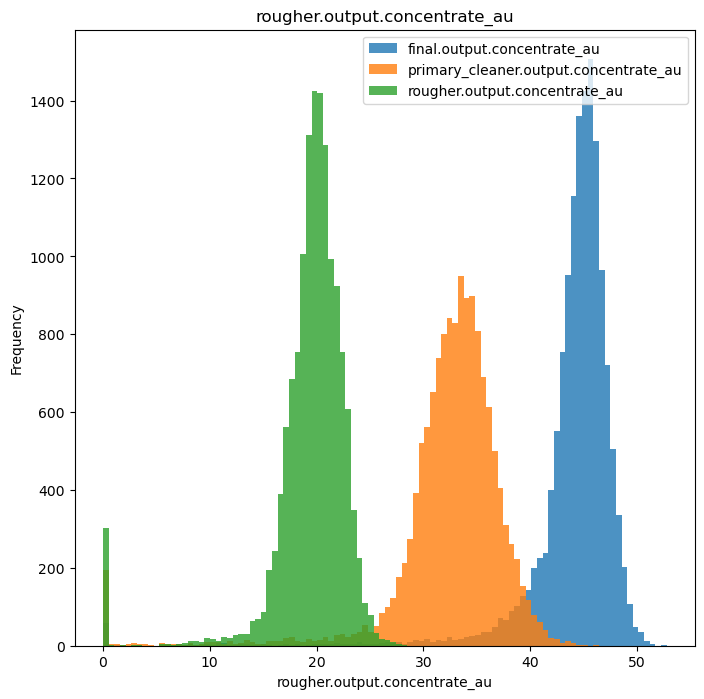

In [51]:
name_au = mineral_plot('au')

In [52]:
df_train[name_au].describe()

,final.output.concentrate_au,primary_cleaner.output.concentrate_au,rougher.output.concentrate_au
count,14149.000000,14149.000000,14149.000000
mean,44.003792,32.386836,19.439958
std,4.905261,5.798843,3.765192
min,0.000000,0.000000,0.000000
25%,43.276111,30.857764,18.432161
50%,44.872436,33.225835,19.947312
75%,46.166425,35.330145,21.392714
max,52.756638,45.933934,28.146838


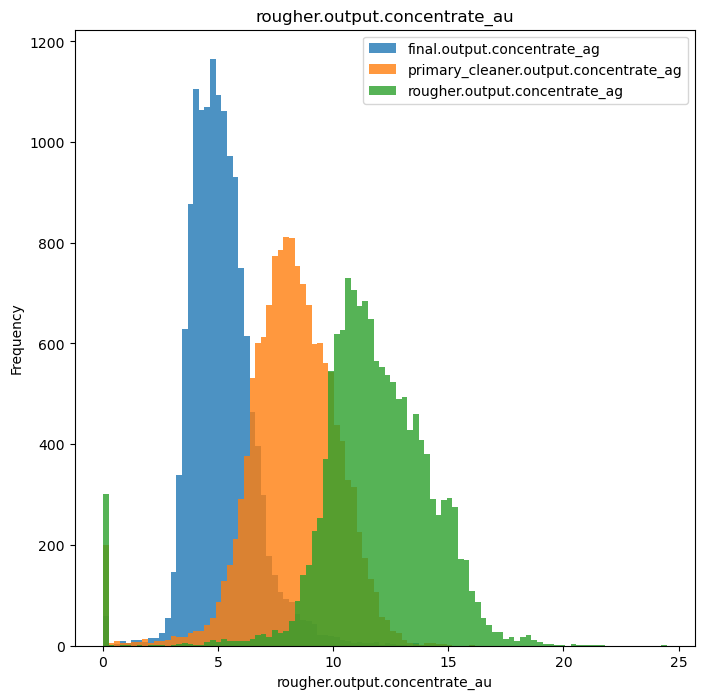

In [53]:
name_ag = mineral_plot('ag')

In [54]:
df_train[name_ag].describe()

,final.output.concentrate_ag,primary_cleaner.output.concentrate_ag,rougher.output.concentrate_ag
count,14149.000000,14149.000000,14149.000000
mean,5.141921,8.200916,11.775812
std,1.369603,2.005185,2.731747
min,0.000000,0.000000,0.000000
25%,4.211500,7.107126,10.486871
50%,4.994607,8.226247,11.747362
75%,5.859495,9.504924,13.426419
max,16.001945,16.081632,24.480271


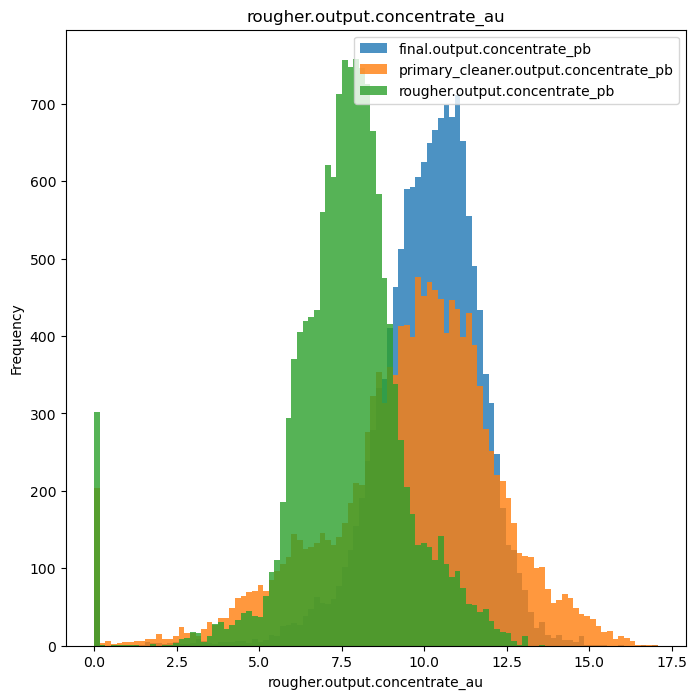

In [55]:
name_pb = mineral_plot('pb')

In [56]:
df_train[name_pb].describe()

,final.output.concentrate_pb,primary_cleaner.output.concentrate_pb,rougher.output.concentrate_pb
count,14149.000000,14149.000000,14149.000000
mean,10.132848,9.568544,7.664555
std,1.654925,2.709330,1.856279
min,0.000000,0.000000,0.000000
25%,9.296833,8.315997,6.850501
50%,10.297013,9.920598,7.760435
75%,11.170578,11.298487,8.601927
max,17.031899,17.081278,13.617072


The concentration of minerals in the ore changes as follows in the ore enrichment process:
- The concentration of gold in the ore, on average, increases by more than 2 times from the flotation stage to the final stage.
- On average, the concentration of silver in the ore from the flotation stage to the final stage decreases by more than 2 times.
- Concentration of lead in the ore increases after the flotation stage. 

For all three minerals in the distributions we observe peak values around zero.

Let's compare the distribution of raw material pellet sizes on the training and test samples. To do this, let's plot Kernel Density Estimation (KDE).

In [57]:
def compare(col):
    df_train[col].plot.kde()
    df_test[col].plot.kde()
    plt.legend(['train', 'test'])

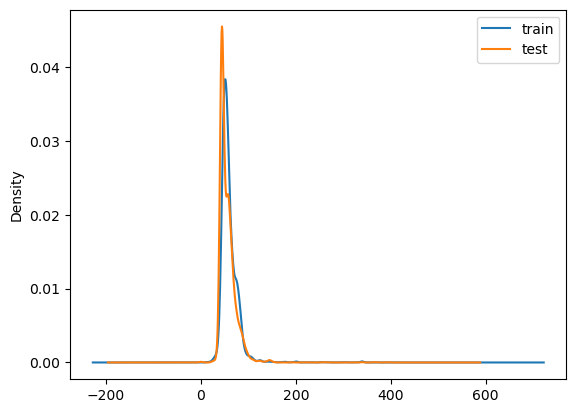

In [58]:
compare('rougher.input.feed_size')

The distributions are similar to each other.

In [59]:
def stage_name(stage):
    list = []
    for i in names:
        if stage in i:
            list.append(i)
    return list

In [60]:
name_final = stage_name('final')
name_rougher = stage_name('rougher')
name_primary = stage_name('primary_cleaner')

In [61]:
name_final

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au']

In [62]:
name_rougher

['rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au']

In [63]:
name_primary

['primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au']

In [64]:
df_train['total_final_concentration'] = df_train[name_final].sum(1)

In [65]:
df_train['total_rougher_concentration'] =  df_train[name_rougher].sum(1)

In [66]:
df_train['total_primary_cleaner_concentration'] =  df_train[name_primary].sum(1)

In [67]:
list = ['total_final_concentration', 'total_rougher_concentration', 'total_primary_cleaner_concentration']

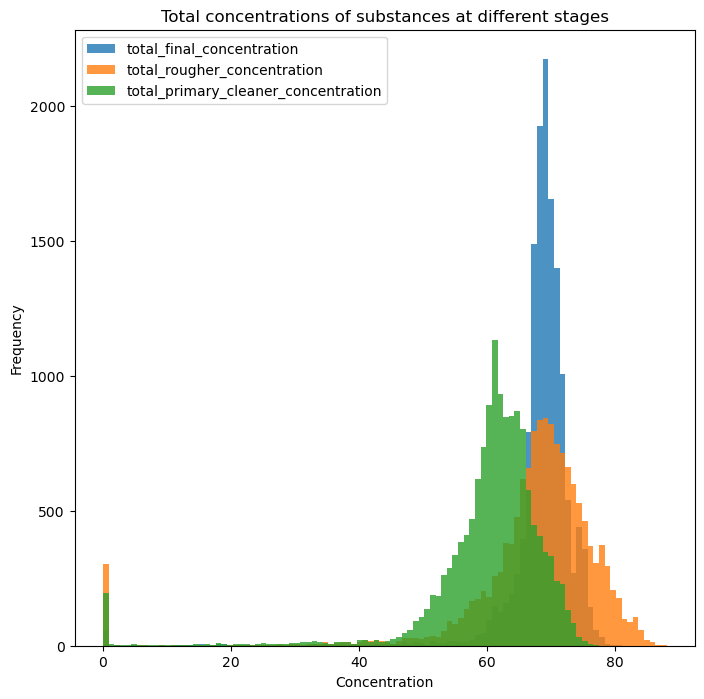

In [68]:
df_train.plot(y=list, kind='hist', alpha=0.8, bins=100, figsize=(8,8))
plt.ylabel('Frequency')
plt.title('Total concentrations of substances at different stages')
plt.xlabel('Concentration')
plt.show()

In [69]:
df_train[list].describe()

,total_final_concentration,total_rougher_concentration,total_primary_cleaner_concentration
count,14149.000000,14149.000000,14149.000000
mean,68.387872,67.173145,60.172546
std,7.023723,12.713129,10.448165
min,0.000000,0.000000,0.000000
25%,67.559819,64.914390,58.046816
50%,69.141502,69.175663,61.786946
75%,70.974661,73.429261,65.355951
max,80.210644,88.140119,76.918076


After flotation, in the primary purification stage, the total concentration of substances in the raw material increases. At the final stage, the total concentration of substances is approximately equal to the concentration at the primary purification stage, but the scatter of values decreases significantly. There is a peak of frequency of cases at concentration equal to zero. Let us look at the lines where the values of the total concentration are less than 10.

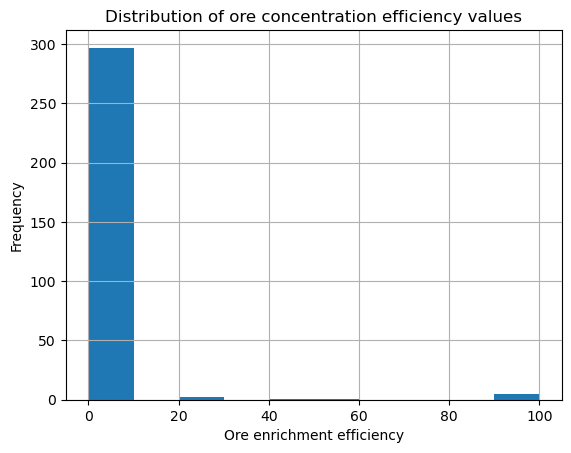

In [70]:
df_train['rougher.output.recovery'][df_train['total_rougher_concentration'] <= 10].hist()
plt.title('Distribution of ore concentration efficiency values')
plt.ylabel('Frequency')
plt.xlabel('Ore enrichment efficiency')
plt.show()

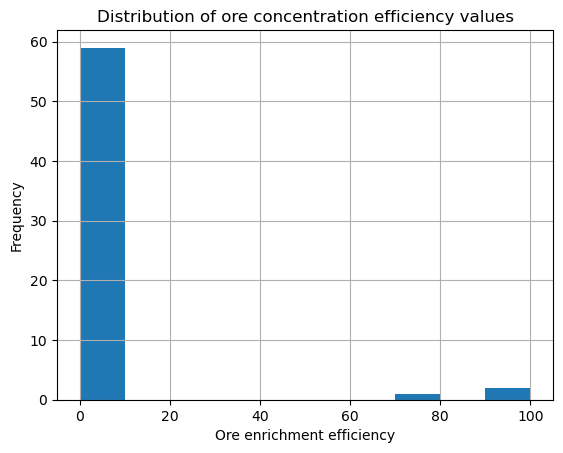

In [71]:
df_train['final.output.recovery'][df_train['total_final_concentration'] <= 10].hist()
plt.title('Distribution of ore concentration efficiency values')
plt.ylabel('Frequency')
plt.xlabel('Ore enrichment efficiency')
plt.show()

Исходя из распределений величин эффективности обогащения руды, можно сделать вывод, что величины, когда суммерная концентрация веществ в сырье меньше или равна 10 скорее всего ошибочные или связаны с неисправностью оборудования. Отберем из тренировочного набора данных строки когда величина суммарной концентрации веществ больше или равна 10.

In [72]:
(df_train['rougher.output.recovery'] == 0).sum()

297

In [73]:
df_train = df_train[df_train['total_final_concentration'] >= 10]
df_train = df_train[df_train['total_rougher_concentration'] >= 10]
df_train = df_train[df_train['total_primary_cleaner_concentration'] >= 10]

In [74]:
(df_train['rougher.output.recovery'] == 0).sum()

0

In [75]:
(df_train['final.output.recovery'] == 0).sum()

0

Нулевых значений в целевых признаках теперь тоже нет

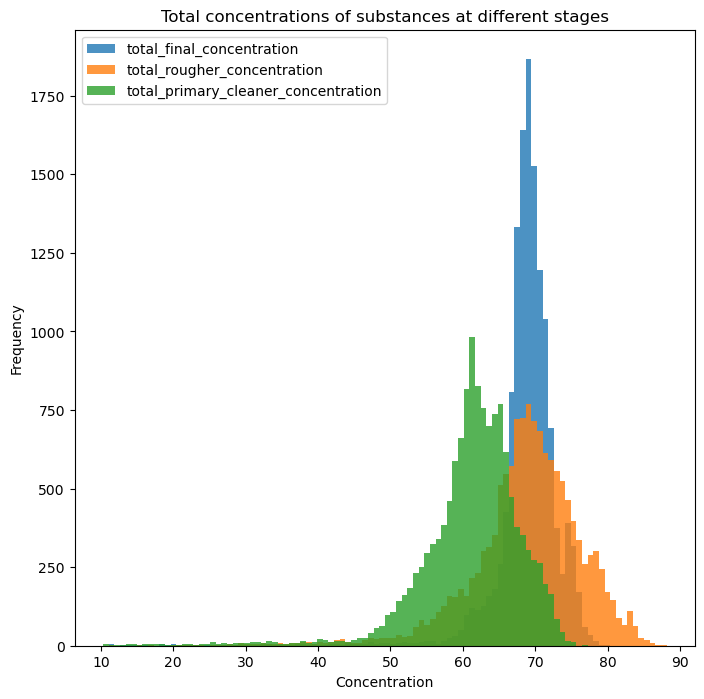

In [76]:
df_train.plot(y=list, kind='hist', alpha=0.8, bins=100, figsize=(8,8))
plt.ylabel('Frequency')
plt.title('Total concentrations of substances at different stages')
plt.xlabel('Concentration')
plt.show()

In [77]:
df_train[list].describe()

,total_final_concentration,total_rougher_concentration,total_primary_cleaner_concentration
count,13570.000000,13570.000000,13570.000000
mean,68.733684,68.716943,61.070812
std,5.153648,7.847176,7.244507
min,11.078117,11.170072,10.292350
25%,67.562408,65.321497,58.319948
50%,69.144880,69.336347,61.851907
75%,70.966582,73.529416,65.366466
max,80.210644,88.140119,76.918076


In [78]:
last_len_train = len(df_train)

In [79]:
last_len_train

13570

In [80]:
first_len_train

14149

In [81]:
rest_len_train = last_len_train/first_len_train

In [82]:
rest_len_train

0.9590783800975334

In [83]:
(df_test['rougher.output.recovery'] == 0).sum()

97

In [84]:
(df_test['final.output.recovery'] == 0).sum()

40

In [85]:
names

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au']

In [86]:
def add_conc(name):
    return df_full[name][df_test.index]
    

In [87]:
for name in names:
    df_test[name] = add_conc(name)

In [88]:
df_test['total_final_concentration'] = df_test[name_final].sum(1)
df_test['total_rougher_concentration'] =  df_test[name_rougher].sum(1)
df_test['total_primary_cleaner_concentration'] =  df_test[name_primary].sum(1)

In [89]:
df_test = df_test[df_test['total_final_concentration'] >= 10]
df_test = df_test[df_test['total_rougher_concentration'] >= 10]
df_test = df_test[df_test['total_primary_cleaner_concentration'] >= 10]

In [90]:
(df_test['rougher.output.recovery'] == 0).sum()

0

In [91]:
(df_test['final.output.recovery'] == 0).sum()

0

In [92]:
df_test = df_test.drop(['final.output.concentrate_ag',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.concentrate_au', 'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
       'rougher.output.concentrate_sol', 'rougher.output.concentrate_au',
       'total_final_concentration', 'total_rougher_concentration',
       'total_primary_cleaner_concentration'], 1)

/tmp/ipykernel_2431/3690288961.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_test = df_test.drop(['final.output.concentrate_ag',


In [93]:
col_delta = col_delta + ['total_final_concentration', 'total_rougher_concentration',
       'total_primary_cleaner_concentration']

In [94]:
df_train = df_train.drop(col_delta, axis = 1)

In [95]:
df_test.shape

(5111, 54)

In [96]:
df_train.shape

(13570, 54)

### Conclusion
Concentration of minerals in the raw material: 

The concentrations of minerals in the raw material change as follows during the ore beneficiation process:
- The concentration of gold in the ore, on average, more than doubles from the flotation stage to the final stage.
- On average, the concentration of silver in the ore from the flotation stage to the final stage decreases by more than 2 times.
- Concentration of lead in the raw material increases after the flotation stage. 

Comparison of raw material pellet size distribution:
- A comparison of raw material pellet size distributions in the training and test samples was performed. The distributions in the samples are similar.

Total Substance Concentration:
- After flotation, in the primary purification stage, the total concentration of substances in the raw material increases. At the final stage, the total concentration of substances is approximately equal to the concentration at the primary purification stage, but the scatter of values decreases significantly. There is a peak in the frequency of cases with a concentration equal to zero. Let's look at the lines where the values of total concentration are less than 10.

Based on the distributions of values of ore concentration efficiency, we can conclude that the values where the total concentration of substances in the raw material is less than or equal to 10 are most likely erroneous or related to equipment malfunction. 
From the test and training data set the lines were selected when the value of total concentration of substances is greater than or equal to 10.

The training and test datasets are ready for training and model validation.

## Model

In [97]:
def smape(y, y_pred):
    numerator = (abs(y - y_pred))
    denominator = (abs(y) + abs(y_pred))/2
    result = 100/len(y)*(numerator/denominator).sum()
    return result

In [98]:
def final_smape(rougher_smape, final_smape):
    return 0.25*rougher_smape + 0.75*final_smape

In [99]:
smape_scorer = make_scorer(smape, greater_is_better=False)

In [100]:
X_train = df_train.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1)
X_test = df_test.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1)
y_train_r = df_train['rougher.output.recovery']
y_train_f = df_train['final.output.recovery']
y_test_r = df_test['rougher.output.recovery']
y_test_f = df_test['final.output.recovery']


In [101]:
scaler = StandardScaler()
scaler.fit(X_train) 

X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)

In [102]:
def linreg(target):
   
    model = LinearRegression()
    model.fit(X_train, target)
    
    score =  (cross_val_score(model, X_train, target, cv=3, scoring = smape_scorer)).mean()*(-1)
    return model, score


In [103]:
rough_linreg_model, lin_rough_score = linreg(y_train_r)

In [104]:
lin_rough_score

10.462806367398178

In [105]:
final_linreg_model, lin_final_score = linreg(y_train_f)

In [106]:
lin_final_score

13.597938561305801

In [107]:
print(lin_rough_score)
print(lin_final_score)

10.462806367398178
13.597938561305801


In [108]:
linearreg_smape = final_smape(lin_rough_score, lin_final_score)
linearreg_smape

12.814155512828895

The final sMAPE on the training dataset after cross-validation is 12.81% at cv=3

In [109]:
def treereg(target):
            
    best_result = 100
    best_predicted_dtr = []
    best_three_model = None
    for depth in tqdm(range(1, 10, 1)):
        dtr = DecisionTreeRegressor(max_depth=depth, random_state=42)
        dtr.fit(X_train_scaled, target)
        result = (cross_val_score(dtr, X_train_scaled, target, cv=3, scoring = smape_scorer)).mean()*(-1)
        if result < best_result:
            best_result = result
            best_depth = depth
            best_tree_model = dtr
            
    return best_tree_model, result, best_depth

In [110]:
rough_treereg_model, tree_rough_score, rough_trees =treereg(y_train_r)

  0%|          | 0/9 [00:00<?, ?it/s]

In [111]:
tree_rough_score

9.019726067021361

In [112]:
rough_trees

3

In [113]:
final_treereg_model, tree_final_score, final_trees =treereg(y_train_f)

  0%|          | 0/9 [00:00<?, ?it/s]

In [114]:
tree_final_score

12.984821441482076

In [115]:
final_trees

1

In [116]:
treereg_smape = final_smape(tree_rough_score, tree_final_score)
treereg_smape

11.993547597866897

The final sMAPE of the best decision tree model after cross-validation is 11.91%

In [117]:
def forestreg(target):
       
    best_result = 100
    best_result2 = 100
    best_predicted_rfr = []
    best_forest_model = None
    for depth in tqdm(range(2, 4, 1)):
        rfr = RandomForestRegressor(max_depth=depth, n_estimators=10, random_state=42)
        rfr.fit(X_train_scaled, target)
        result = (cross_val_score(rfr, X_train_scaled, target, cv=3, scoring = smape_scorer)).mean()*(-1)
        if result < best_result:
            best_result = result
            best_depth = depth
    for est in tqdm(range(50,150,50)):
        rfr = RandomForestRegressor(max_depth=best_depth, n_estimators=est, random_state=42)
        rfr.fit(X_train_scaled, target)
        result = (cross_val_score(rfr, X_train_scaled, target, cv=3, scoring = smape_scorer)).mean()*(-1)
        if result < best_result2:
            best_result = result
            best_est = est
            best_forest_model = rfr
            
    return best_forest_model, result, best_depth, best_est

In [118]:
rough_forestreg_model, forest_rough_score, rough_ftrees, rough_est =forestreg(y_train_r)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [119]:
 forest_rough_score, rough_ftrees, rough_est

(8.001607031726573, 3, 100)

In [120]:
final_forestreg_model, forest_final_score, final_ftrees, final_est =forestreg(y_train_f)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [121]:
forest_final_score, final_ftrees, final_est

(9.872845577824272, 2, 100)

In [122]:
forestreg_smape = final_smape(forest_rough_score, forest_final_score)
forestreg_smape

9.405035941299847

The final sMAPE of the Random Forest regression model after cross-validation was 9.41%

In [123]:
linearreg_smape, treereg_smape, forestreg_smape

(12.814155512828895, 11.993547597866897, 9.405035941299847)

Three models were trained and cross-validated, and the final sMAPE values for the models were as follows:
- LinearRegression - 12.81
- DecisionTreeRegressor - 11.91
- RandomForestRegressor - 9.41

#### Validation on a test sample

In [124]:
rough_test_score = smape(rough_forestreg_model.predict(X_test_scaled), y_test_r)

In [125]:
rough_test_score

4.648691367270704

In [126]:
final_test_score = smape(final_forestreg_model.predict(X_test_scaled), y_test_f)
final_test_score

7.677797661012756

In [127]:
test_smape = final_smape(rough_test_score, final_test_score)
test_smape

6.920521087577243

The result of testing the Random Forest regression model on the test sample:
- sMape = 6.92%

### Output
- The function for calculating sMape mktric has been written.
- Three models were trained and tested by cross validation. After selecting hyperparameters, the best model was selected based on RandomForrestRegresor. The results for the Linear Regression, Decision Tree and Random Forest models are 12.81%, 11.91% and 9.41% respectively. 
- The best model is tested on a test dataset, the result is sMAPE = 6.92%